In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd

In [2]:
# Precipitação CHIRPS (mensal)
precip = xr.open_dataarray("dataset/netcdf_data/chirps_mensal_1981_2023.nc")


# Exemplo: xr.open_mfdataset("dataset/sst_global/sst_global_*.nc")
sst = xr.open_mfdataset("dataset/sst_global/sst_atlantico_*.nc")["analysed_sst"]
sst_mensal = sst - 273.15  # Converter de Kelvin para Celsius

In [18]:
sst_mensal

<xarray.DataArray 'analysed_sst' (time: 504, latitude: 300, longitude: 650)> Size: 393MB
dask.array<sub, shape=(504, 300, 650), dtype=float32, chunksize=(1, 300, 650), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 4kB 1982-01-16 ... 2023-12-16
  * longitude  (longitude) float64 5kB -49.95 -49.85 -49.75 ... 14.85 14.95
  * latitude   (latitude) float64 2kB -14.95 -14.85 -14.75 ... 14.75 14.85 14.95

In [7]:
# Mensal -> climatologia mensal -> anomalia
sst_clim = sst_mensal.groupby("time.month").mean("time")

sst_anom = sst_mensal.groupby("time.month") - sst_clim

sst_anom_media = sst_anom.mean(dim=("latitude","longitude"))


In [13]:
# Selecionar período comum (1982-2023)
precip_serie = precip.mean(dim=("lat","lon"))
precip_serie = precip_serie.sortby("time")
precip_serie = precip_serie.sel(time=slice("1982-01-01", "2023-12-31"))

In [5]:
# Calcular percentil 95 mensal para cada pixel (base climatológica mensal)
p95_mensal = precip.reduce(np.nanpercentile, q=95, dim="time")

# Média espacial do percentil 95 (mensal)
p95_series = precip.reduce(np.nanpercentile, q=95, dim=["lat","lon"])

# Série temporal do percentil 95 mensal (média espacial)
p95_mensal_series = precip.groupby("time").reduce(np.nanpercentile, q=95, dim=("lat","lon"))

# Selecionar período comum (1982-2023)
p95_mensal_series = p95_mensal_series.sortby("time")
p95_mensal_series = p95_mensal_series.sel(time=slice("1982-01-01", "2023-12-31"))

In [9]:
def serie_sazonal_media(serie_mensal_1d, months, lag_meses=0):
    """
    Agrega uma série mensal 1D por estação-ano.
    - months: lista de meses da estação (ex.: [12,1,2] para DJF, [3,4,5] para MAM)
    - lag_meses: defasagem aplicada ANTES (positivo = SST lidera)
    Retorna: DataArray 1D indexado por 'season_year' (inteiro).
    """
    # 1) aplica defasagem se houver
    s = serie_mensal_1d.shift(time=lag_meses) if lag_meses else serie_mensal_1d

    # 2) extrai mês/ano
    mo = s["time.month"]
    yr = s["time.year"]

    # 3) define o "ano da estação" (dezembro conta pro ano seguinte, se for DJF)
    if 12 in months:
        season_year = xr.where(mo == 12, yr + 1, yr)
    else:
        season_year = yr

    # 4) filtra apenas os meses da estação
    sel = mo.isin(months)
    s_sel  = s.where(sel, drop=True)
    sy_sel = season_year.where(sel, drop=True)

    # 5) *** ponto crítico ***: usar .values (numpy) e, de preferência, int
    sy_vals = sy_sel.values.astype(int)

    # 6) agrega por season_year (média dos 3 meses)
    s_sazonal = (
        s_sel
        .assign_coords(season_year=("time", sy_vals))
        .groupby("season_year")
        .mean("time")
    )
    return s_sazonal


In [ ]:
DJF = [12, 1, 2]
MAM = [3, 4, 5]

# Chuva P95 (sazonal)
p95_DJF = serie_sazonal_media(precip_serie, DJF, lag_meses=0)
p95_MAM = serie_sazonal_media(precip_serie, MAM, lag_meses=0)

# SST anômala média (sazonal) - SEM defasagem
sst_DJF_0 = serie_sazonal_media(sst_anom_media, DJF, lag_meses=0)
sst_MAM_0 = serie_sazonal_media(sst_anom_media, MAM, lag_meses=0)

# SST anômala média (sazonal) - COM defasagem de +3 meses (SST lidera 3 meses)
sst_DJF_3 = serie_sazonal_media(sst_anom_media, DJF, lag_meses=3)
sst_MAM_3 = serie_sazonal_media(sst_anom_media, MAM, lag_meses=3)


In [15]:
def corr_spearman_por_estacao(x, y):
    # alinhar por season_year
    xa, ya = xr.align(x, y, join="inner")
    # remover NaN
    mask = (~np.isnan(xa)) & (~np.isnan(ya))
    rho, p = spearmanr(xa.values[mask], ya.values[mask])
    return float(rho), float(p), xa["season_year"].values[mask]

# DJF
rho_DJF_0, p_DJF_0, anos_DJF = corr_spearman_por_estacao(p95_DJF, sst_DJF_0)
rho_DJF_3, p_DJF_3, _        = corr_spearman_por_estacao(p95_DJF, sst_DJF_3)

# MAM
rho_MAM_0, p_MAM_0, anos_MAM = corr_spearman_por_estacao(p95_MAM, sst_MAM_0)
rho_MAM_3, p_MAM_3, _        = corr_spearman_por_estacao(p95_MAM, sst_MAM_3)

print(f"DJF | defasagem 0m:  ρ={rho_DJF_0:.2f}, p={p_DJF_0:.3f}")
print(f"DJF | defasagem 3m:  ρ={rho_DJF_3:.2f}, p={p_DJF_3:.3f}")
print(f"MAM | defasagem 0m:  ρ={rho_MAM_0:.2f}, p={p_MAM_0:.3f}")
print(f"MAM | defasagem 3m:  ρ={rho_MAM_3:.2f}, p={p_MAM_3:.3f}")


DJF | defasagem 0m:  ρ=0.14, p=0.384
DJF | defasagem 3m:  ρ=0.13, p=0.413
MAM | defasagem 0m:  ρ=0.14, p=0.368
MAM | defasagem 3m:  ρ=0.09, p=0.576


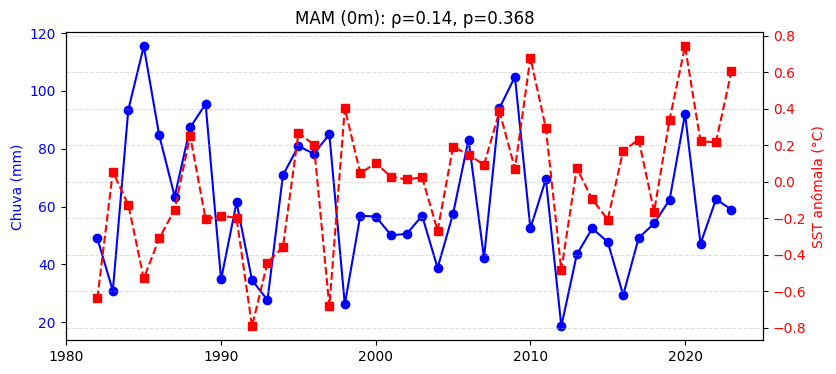

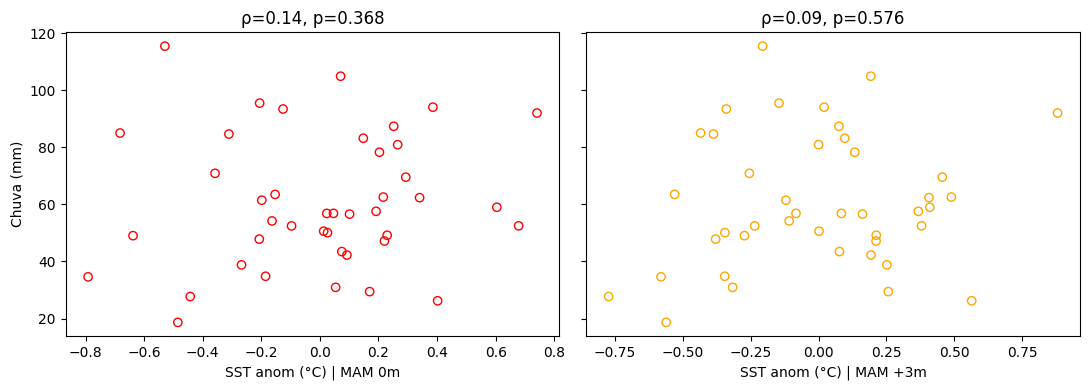

In [18]:
# Séries DJF (sem lag)
fig, ax1 = plt.subplots(figsize=(9,4))
ax1.plot(anos_MAM, p95_MAM.sel(season_year=anos_MAM), "o-", color="blue", label="Chuva (MAM)")
ax1.set_ylabel("Chuva (mm)", color="blue"); ax1.tick_params(axis='y', labelcolor="blue")
ax2 = ax1.twinx()
ax2.plot(anos_MAM, sst_MAM_0.sel(season_year=anos_MAM), "s--", color="red", label="SST anom (MAM)")
ax2.set_ylabel("SST anômala (°C)", color="red"); ax2.tick_params(axis='y', labelcolor="red")
plt.title(f"MAM (0m): ρ={rho_MAM_0:.2f}, p={p_MAM_0:.3f}")
plt.grid(True, ls="--", alpha=0.4)
plt.show()

# Dispersão MAM (0m e +3m)
fig, axes = plt.subplots(1,2, figsize=(11,4), sharey=True)
xa, ya0 = xr.align(p95_MAM, sst_MAM_0, join="inner")
mask0 = (~np.isnan(xa)) & (~np.isnan(ya0))
axes[0].scatter(ya0.values[mask0], xa.values[mask0], facecolor="none", edgecolor="red")
axes[0].set_xlabel("SST anom (°C) | MAM 0m"); axes[0].set_ylabel("Chuva (mm)")
axes[0].set_title(f"ρ={rho_MAM_0:.2f}, p={p_MAM_0:.3f}")

xa, ya3 = xr.align(p95_MAM, sst_MAM_3, join="inner")
mask3 = (~np.isnan(xa)) & (~np.isnan(ya3))
axes[1].scatter(ya3.values[mask3], xa.values[mask3], facecolor="none", edgecolor="orange")
axes[1].set_xlabel("SST anom (°C) | MAM +3m")
axes[1].set_title(f"ρ={rho_MAM_3:.2f}, p={p_MAM_3:.3f}")
plt.tight_layout(); plt.show()

# Repita para MAM se quiser:
# (análogos substituindo DJF por MAM)


In [5]:
sst_3m = sst_anom_media.shift(time=3)
sst_6m = sst_anom_media.shift(time=6)


In [6]:
def correlacao_spearman_series(x, y):
    # Garante alinhamento via mask
    mask = (~np.isnan(x)) & (~np.isnan(y))
    return spearmanr(x[mask], y[mask])

In [7]:

# Calcular correlações
corr_0, p_0 = correlacao_spearman_series(p99_mensal_series.values, sst_anom_media.values)
corr_3, p_3 = correlacao_spearman_series(p99_mensal_series.values, sst_3m.values)
corr_6, p_6 = correlacao_spearman_series(p99_mensal_series.values, sst_6m.values)

print(f"Sem defasagem:  ρ = {corr_0:.2f}, p = {p_0:.3f}")
print(f"Defasagem 3m:   ρ = {corr_3:.2f}, p = {p_3:.3f}")
print(f"Defasagem 6m:   ρ = {corr_6:.2f}, p = {p_6:.3f}")


Sem defasagem:  ρ = 0.01, p = 0.762
Defasagem 3m:   ρ = 0.03, p = 0.472
Defasagem 6m:   ρ = 0.08, p = 0.071


In [8]:
# --- Carregar shapefile ---
shapefile_path = "dataset/shape/caatinga_estados.shp"
gdf_estados = gpd.read_file(shapefile_path)

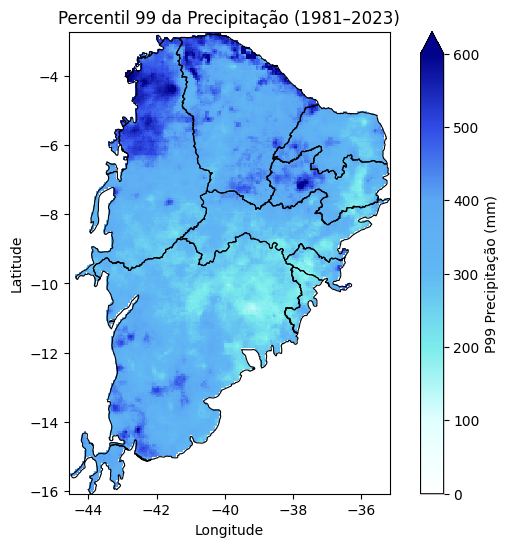

In [9]:
# Criar colormap: branco para 0 e tons de azul até 450 mm
# Definir sequência de cores desejadas

#colors = ["#FFFFFF", "#F0FFF0", "#98FB98", "#3CB371", "#2E8B57", "#228B22", "#006400"]
#colors = ["#FFFFFF", "#F0F8FF", "#ADD8E6", "#4682B4", "#4169E1", "#0000CD", "#00008B"]

#colors = ["#FFFFFF", "#E0FFFF", "#00FF7F", "#32CD32", "#8FBC8F", "#6B8E23", "#006400"]
#colors = ["#FFFFFF","#E0FFFF","#00FF7F", "#4ADB4A","#50AD12","#487205",  "#014601"]
colors = ["#FFFFFF","#E0FFFF","#7BECEC", "#60B8F3", "#5CA8F3","#304BE6","#02028B"]
# springgreen->lightcyan->darkseagreen->olivedrab->limegreen->darkgreen 

# Criar colormap
cmap_custom = mcolors.LinearSegmentedColormap.from_list("white_to_darkblue", colors)

plt.figure(figsize=(8,6))
p = p99_mensal.plot(
    cmap=cmap_custom,
    vmin=0, vmax=600, 
    cbar_kwargs={
        "label": "P99 Precipitação (mm)"
        #,
        #"ticks": np.arange(0, 601) #, 50
    }
)

# Adicionar contorno dos estados (sem preenchimento)
gdf_estados.boundary.plot(ax=plt.gca(), color='black', linewidth=0.8)

plt.title("Percentil 99 da Precipitação (1981–2023)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

AttributeError: Rectangle.set() got an unexpected keyword argument 'cmap'

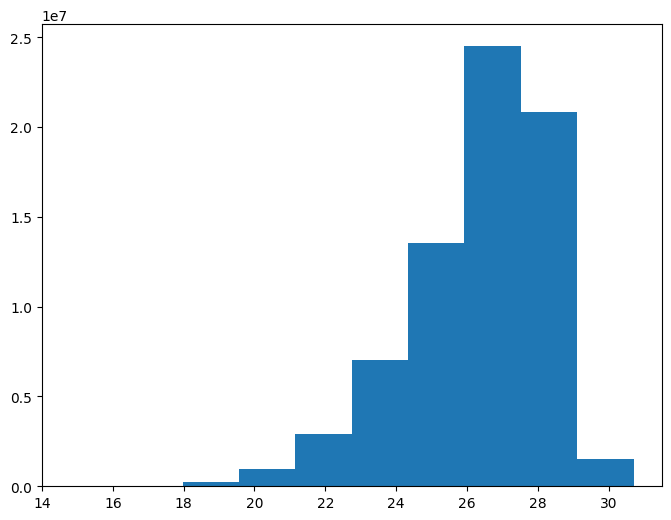

In [20]:
#sst_anom.plot(label="SST Anomalia Média (°C)")

plt.figure(figsize=(8,6))
p = sst_mensal.plot(
    cmap=cmap_custom,
    vmin=15, vmax=31, 
    cbar_kwargs={
        "label": "P99 Precipitação (mm)"
        #,
        #"ticks": np.arange(0, 601) #, 50
    }
)

In [ ]:
def mann_kendall_test(series):
    n = len(series)
    s = 0
    for k in range(n-1):
        s += np.sum(np.sign(series[k+1:] - series[k]))
    var_s = n*(n-1)*(2*n+5)/18
    if s > 0:
        z = (s-1)/np.sqrt(var_s)
    elif s < 0:
        z = (s+1)/np.sqrt(var_s)
    else:
        z = 0
    p = 2*(1-norm.cdf(abs(z)))
    return z, p

def sens_slope(series, anos):
    slopes = []
    n = len(series)
    for i in range(n-1):
        slopes.extend((series[i+1:] - series[i]) / (anos[i+1:] - anos[i]))
    return np.median(slopes)


In [ ]:
# P99
z_p99, p_p99 = mann_kendall_test(p99_common.values)
slope_p99 = sens_slope(p99_common.values, anos_comuns)

# SST
z_sst, p_sst = mann_kendall_test(sst_common.values)
slope_sst = sens_slope(sst_common.values, anos_comuns)

print(f"P99 - Z: {z_p99:.2f}, p: {p_p99:.3f}, slope: {slope_p99:.3f} mm/ano")
print(f"SST - Z: {z_sst:.2f}, p: {p_sst:.3f}, slope: {slope_sst:.3f} °C/ano")


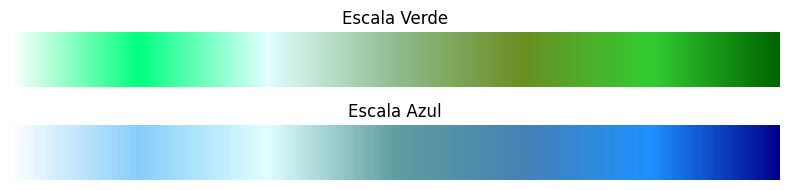

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Escalas
verde = ["#FFFFFF", "#00FF7F", "#E0FFFF", "#8FBC8F", "#6B8E23", "#32CD32", "#006400"]
azul = ["#FFFFFF", "#87CEFA", "#E0FFFF", "#5F9EA0", "#4682B4", "#1E90FF", "#00008B"]

# Função para criar gradiente
def plot_gradients(colors_list, title):
    n_colors = len(colors_list)
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    fig, ax = plt.subplots(figsize=(8, 2))
    ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap('Greens'))
    ax.axis('off')

# Criação de gradientes customizados
def create_custom_cmap(colors):
    from matplotlib.colors import LinearSegmentedColormap
    return LinearSegmentedColormap.from_list("custom", colors)

cmap_verde = create_custom_cmap(verde)
cmap_azul = create_custom_cmap(azul)

fig, axs = plt.subplots(2, 1, figsize=(8, 2))

# Gradiente verde
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
axs[0].imshow(gradient, aspect='auto', cmap=cmap_verde)
axs[0].set_title("Escala Verde")
axs[0].axis('off')

# Gradiente azul
axs[1].imshow(gradient, aspect='auto', cmap=cmap_azul)
axs[1].set_title("Escala Azul")
axs[1].axis('off')

plt.tight_layout()
plt.show()


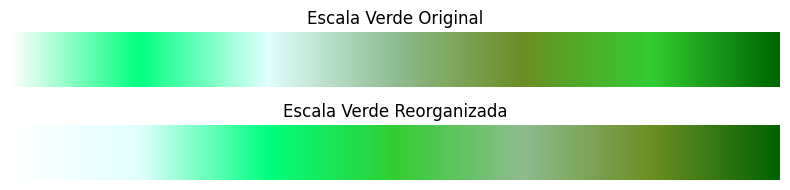

In [2]:
# Escala verde reorganizada para progressão fluida
verde_reorganizado = ["#FFFFFF", "#E0FFFF", "#00FF7F", "#32CD32", "#8FBC8F", "#6B8E23", "#006400"]

# Criar colormaps
cmap_verde_original = create_custom_cmap(verde)
cmap_verde_reorganizado = create_custom_cmap(verde_reorganizado)

fig, axs = plt.subplots(2, 1, figsize=(8, 2))

# Gradiente original
axs[0].imshow(gradient, aspect='auto', cmap=cmap_verde_original)
axs[0].set_title("Escala Verde Original")
axs[0].axis('off')

# Gradiente reorganizado
axs[1].imshow(gradient, aspect='auto', cmap=cmap_verde_reorganizado)
axs[1].set_title("Escala Verde Reorganizada")
axs[1].axis('off')

plt.tight_layout()
plt.show()
